#### SVM 实现（改进版）

In [1]:
# (1) 导入相关包

from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Circle

In [2]:
# (2) 加载数据

def loaddata(fileName):
    dataMat = []; labelMat = [];
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

In [3]:
# (3) 随机选择第二个样本
def selectJrand(i,m):
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

In [4]:
# (4) 剪辑
def clipAlpha(aj,H,L):
    if aj>H:
        aj = H
    if aj<L:
        aj = L
    return aj

##### 改进点：选择第二个待优化的$\alpha_j$时，选择误差最大的那个

In [50]:
# 定义一个新的数据结构
class optStruct:
    def __init__(self,dataMatIn,classLabels,C,toler):
        self.dataMatrix = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = matrix(zeros((self.m,1)))
        self.b = 0
        self.eCache = matrix(zeros((self.m,2))) # 第一列代表标识位，0无效，1有效；第二列样本对应的Ei值

In [130]:
# 计算Ek
def calEk(oS,k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T * (oS.dataMatrix*(oS.dataMatrix[k,:].T))) + oS.b

#    print(type(oS.b))
    Ek = fXk - float(oS.labelMat[k])
#    print(Ek)
#    print(type(Ek))
    return Ek

In [100]:
# 选择与Ei相差最大的那个j
def selectJ(i,oS,Ei):
    maxK = -1; Ej = 0 # 记录与Ei相差最大的j和Ej值
    maxDeltaE = 0;

    oS.eCache[i,:] = [1,Ei] # 设为有效
    validEcacheList = nonzero(oS.eCache[:,0].A)[0] # 取出所有有效的Ek
    if (len(validEcacheList))>1:
        for k in validEcacheList:
            if k==i: continue # 不能与i相等
            Ek = calEk(oS,k)
            deltaE = abs(Ei-Ek)
            if(deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else: # 如果没有有效的Ek,随机选择一个
        j = selectJrand(i,oS.m)
        Ej = calEk(oS,j)
        return j, Ej

In [76]:
# 更新缓存
def updateEk(oS,k):
    Ek = calEk(oS,k)
    oS.eCache[k,:] = [1,Ek]

In [145]:
# 更新参数，返回是否更新成功
def innerL(i,oS):
    Ei = calEk(oS,i)
    print(Ei)
    if((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i]<oS.C)) or ((oS.labelMat[i]*Ei>oS.tol) and (oS.alphas[i]>0)):
        j, Ej = selectJ(i,oS,Ei) # 不再随机选取，而是选择与Ei相差最大的
        alphaIold = oS.alphas[i,0].copy()
        alphaJold = oS.alphas[j,0].copy()

        # 计算eta
        eta = 2.0*oS.dataMatrix[i,:]*oS.dataMatrix[j,:].T - oS.dataMatrix[i,:]*oS.dataMatrix[i,:].T - oS.dataMatrix[j,:]*oS.dataMatrix[j,:].T
        if eta >= 0: print("eta>=0"); return 0 # 理论上来说，eta始终小于0
        
        # 计算上下界
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max([0,alphaJold-alphaIold])
            H = min([oS.C,oS.C-alphaIold+alphaJold])
        else:
            L = max([0,alphaJold+alphaIold-oS.C])
            H = min([oS.C,alphaIold+alphaJold])

        if L==H: print("L==H"); return 0

         # 计算alphaj并剪辑
        oS.alphas[j,0] -= oS.labelMat[j]*(Ei-Ej)/eta
        oS.alphas[j,0] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j) # 更新缓存

        if (abs(oS.alphas[j,0] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        # 计算alpha i 
        oS.alphas[i,0] += oS.labelMat[i]*oS.labelMat[j]*(alphaJold - oS.alphas[j,0])
        
        # 计算b1
        b1 = -Ei + oS.labelMat[i]*oS.dataMatrix[i,:]*(oS.dataMatrix[i,:].T) * (alphaIold - oS.alphas[i,0]) + oS.labelMat[j]*oS.dataMatrix[i,:]*(oS.dataMatrix[j,:].T) * (alphaJold - oS.alphas[j,0]) +  oS.b
        # 计算b2
        b2 = -Ej + oS.labelMat[i]*oS.dataMatrix[i,:]*(oS.dataMatrix[j,:].T) * (alphaIold - oS.alphas[i,0]) + oS.labelMat[j]*oS.dataMatrix[j,:]*(oS.dataMatrix[j,:].T) * (alphaJold - oS.alphas[j,0]) +  oS.b
        
        # 决定b
        if (oS.alphas[i]>0) and (oS.alphas[i]<oS.C): 
            oS.b = b1[0][0]
        elif (oS.alphas[j]>0) and (oS.alphas[j]<oS.C):
            oS.b = b2[0][0]
        else:
            oS.b = (b1[0][0]+b2[0][0])/2.0
        return 1
    else:
        return 0

In [139]:
nonzero(E[:,0].A)[0]

array([1])

In [140]:
# (6) 改进的SMO算法
def smoP(dataMatIn,classLabels,C,toler,maxIter):
    oS = optStruct(matrix(dataMatIn),matrix(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while(iter<maxIter) and ((alphaPairsChanged>0) or entireSet): # 如果未达到最大迭代次数，或者上一次迭代时，有成功更新
        alphaPairsChanged = 0
        if entireSet: # 遍历全部数据集
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i: %d, pairs changed: %d" % (iter, i, alphaPairsChanged))
            iter += 1
        else: # 遍历非边界数据集
            nonBoundIs = nonzero((oS.alphas.A>0) * (oS.alphas.A<C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i: %d, pairs changed: %d" % (iter, i, alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged==0):
            entireSet = True
        print("iteration num: %d" % iter)
    return oS.b, oS.alphas
        

In [141]:
def calcWs(alphas,dataArr,classLabels):
    X = matrix(dataArr); labelMat = matrix(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

1.0
<class 'numpy.matrix'>
fullSet, iter: 0 i: 0, pairs changed: 1
[[-0.29781118]]
fullSet, iter: 0 i: 1, pairs changed: 1
[[0.15484367]]
fullSet, iter: 0 i: 2, pairs changed: 1
[[-0.30208703]]
fullSet, iter: 0 i: 3, pairs changed: 1
[[-0.0176539]]


/tmp/ipykernel_253559/3495206355.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fXk = float(multiply(oS.alphas,oS.labelMat).T * (oS.dataMatrix*(oS.dataMatrix[k,:].T))) + oS.b
/tmp/ipykernel_253559/3495206355.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ek = fXk - float(oS.labelMat[k])
/tmp/ipykernel_253559/2688189026.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  oS.alphas[j,0] -= oS.labelMat[j]*(Ei-Ej)/eta
/tmp/ipykernel_253559/2688189026.py:26: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

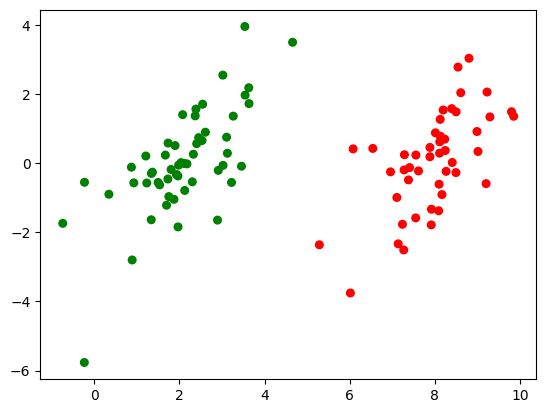

In [146]:
dataMat,labelMat = loaddata('data/svm1.txt')
#画图
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)
# plt.show()
###########
b,alphas = smoP(dataMat,labelMat,0.6,0.001,40)
w = calcWs(alphas,dataMat,labelMat)
print('b=',b)
print('alphas=',alphas)
print('w=',w)

In [78]:
eCache = matrix(zeros((5,2))) 

In [79]:
eCache

matrix([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [80]:
eCache[2,:] = [1,2.1]

In [81]:
eCache

matrix([[0. , 0. ],
        [0. , 0. ],
        [1. , 2.1],
        [0. , 0. ],
        [0. , 0. ]])